# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
January, 2022

## Dimuon mass spectrum calculation with Spark DataFrame API

In [1]:
# Download the data (2 GB) if not yet available locally

! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet

--2024-04-08 16:49:01--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet
Resolving sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)... 2001:1458:d00:62::100:2e8, 2001:1458:d00:16::41d, 2001:1458:d00:65::100:265, ...
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|2001:1458:d00:62::100:2e8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1971962857 (1.8G)
Saving to: ‘Run2012BC_DoubleMuParked_Muons.parquet’

100%[====================================>] 1,971,962,857 43.3MB/s   in 23s    

2024-04-08 16:49:24 (82.5 MB/s) - ‘Run2012BC_DoubleMuParked_Muons.parquet’ saved [1971962857/1971962857]



In [2]:
# Install PySpark if needed

# !pip install pyspark

# Install sparkhistogram
# Note: if you cannot install the package, create the computeHistogram
# function as detailed at the end of this notebook.

!pip install sparkhistogram


  Obtaining dependency information for sparkhistogram from https://files.pythonhosted.org/packages/1b/b0/2a6d47e5a5eaf77337805859d4dcb33a87849c97f354515499b66826989f/sparkhistogram-0.3-py2.py3-none-any.whl.metadata


In [10]:
# Start the Spark Session
# This uses local mode for simplicity

# note this uses Parquet vectorized reader for nested columns,
# default to True in Spark 3.4 and higher
# .config("spark.sql.parquet.enableNestedColumnVectorizedReader", "true")


from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("dimuon mass")
         .master("local[4]")
         .config("spark.driver.memory", "2g")
         .getOrCreate()
        )

24/04/08 22:21:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [11]:
# Read data with the muon candidate events

path = "./"
df_muons = spark.read.parquet(path + "Run2012BC_DoubleMuParked_Muons.parquet")

df_muons.printSchema()
print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)

Number of events: 61540413


In [12]:
# Apply filters to the input data
# - select only events with 2 muons
# - select only events where the 2 muons have opposite charge

df_muons = df_muons.filter("nMuon == 2").filter("Muon_charge[0] != Muon_charge[1]")


In [13]:
# This computes the 4-vectors sum for the 2 moun system
# using formulas from special relativity, in the limit E >> muons rest mass
# see also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
# and https://en.wikipedia.org/wiki/Invariant_mass

df_with_dimuonmass = df_muons.selectExpr("""
     sqrt(2 * Muon_pt[0] * Muon_pt[1] * 
             ( cosh(Muon_eta[0] - Muon_eta[1]) - cos(Muon_phi[0] - Muon_phi[1]) )
         ) as Dimuon_mass""")

In [14]:
# This defines the DataFrame transformation to compute the Dimuon mass spectrum
# The result is a histogram with (energy) bin values and event counts foreach bin

# Requires sparkhistogram
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 
from sparkhistogram import computeHistogram

# histogram parameters
min_val = 0.25
max_val = 300
num_bins = 30000

# use the helper function computeHistogram in the package sparkhistogram
histogram_data = computeHistogram(df_with_dimuonmass, "Dimuon_mass", min_val, max_val, num_bins) 


In [15]:
# The action toPandas() triggers the computation (Spark uses lazy evaluation)
# Histogram data is fetched into the driver as a Pandas DataFrame.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 161 ms, sys: 13.7 ms, total: 175 ms
Wall time: 10.1 s


In [16]:
# Preview of the histogram data
histogram_data_pandas.head(5)

,bucket,value,count
0,1,0.254995833333333,19679
1,2,0.264987500000000,19285
2,3,0.274979166666667,18972
3,4,0.284970833333333,18543
4,5,0.294962500000000,18520


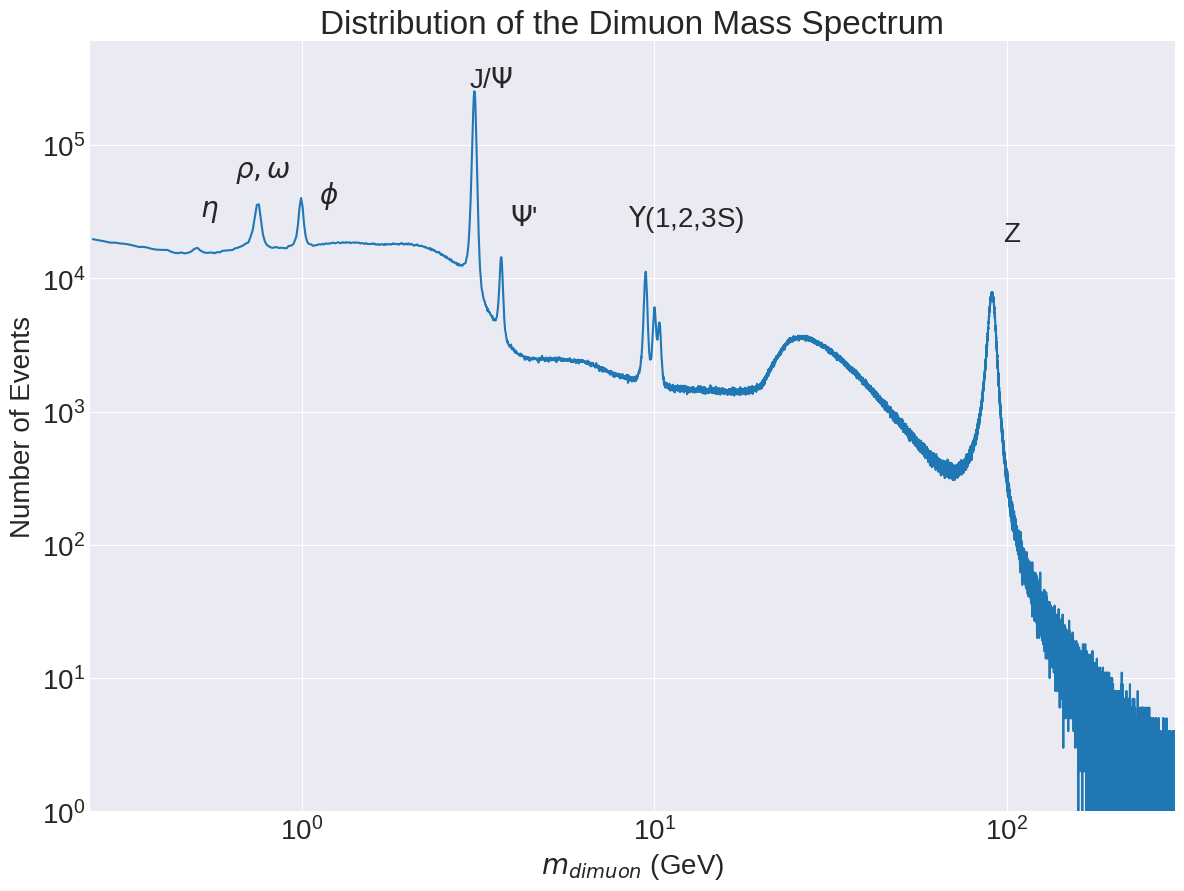

In [17]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()

In [18]:
spark.stop()

## Note on sparkhistogram 

Use this to define the computeHistogram function if you cannot pip install sparkhistogram


In [ ]:
def computeHistogram(df: "DataFrame", value_col: str, min: float, max: float, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the count/frequecy histogram of a column
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: number of values in the bucket        
    """
    step = (max - min) / bins
    # this will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.sql(f"select id+1 as bucket from range({bins})")
    
    histdf = (df
              .selectExpr(f"width_bucket({value_col}, {min}, {max}, {bins}) as bucket")
              .groupBy("bucket")
              .count()
              .join(df_buckets, "bucket", "right_outer") # add missing buckets and remove buckets out of range
              .selectExpr("bucket", f"{min} + (bucket - 1/2) * {step} as value", # use center value of the buckets
                          "nvl(count, 0) as count") # buckets with no values will have a count of 0
              .orderBy("bucket")
             )
    return histdf